## Weight  of evidence

Weight of Evidence (WoE) was developed primarily for the credit and financial industries to help build more predictive models to evaluate the risk of loan default. That is, to predict how likely the money lent to a person or institution is to be lost. Thus, Weight of Evidence is a measure of the "strength” of a grouping technique to separate good and bad risk (default). 

- WoE will be 0 if the P(Goods) / P(Bads) = 1, that is, if the outcome is random for that group.
- If P(Bads) > P(Goods) the odds ratio will be < 1 and,
- WoE will be < 0 if,  P(Goods) > P(Bads).

WoE is well suited for Logistic Regression, because the Logit transformation is simply the log of the odds, i.e., ln(P(Goods)/P(Bads)). Therefore, by using WoE-coded predictors in logistic regression, the predictors are all prepared and coded to the same scale, and the parameters in the linear logistic regression equation can be directly compared.

The WoE transformation has three advantages:

- It creates a monotonic relationship between the target and the independent variables.
- It orders the categories on a "logistic" scale which is natural for logistic regression
- The transformed variables can then be compared because they are on the same scale. Therefore, it is possible to determine which one is more predictive.

The WoE also has a limitation:

- Prone to cause over-fitting


For more details follow this [article](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html#Steps-of-Calculating-WOE) and this [article](https://blogs.oracle.com/r/computing-weight-of-evidence-woe-and-information-value-iv).


## In this demo:

We will see how to perform one hot encoding with:
- pandas
- Feature-Engine
- Category encoders

And the advantages and limitations of each implementation using the Titanic dataset.

In [7]:
# import libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from feature_engine.encoding import WoEEncoder as fe_WoEEncoder
from category_encoders.woe import WOEEncoder

In [72]:
# load data

cols = ['cabin', 'sex', 'embarked', 'survived']

data = pd.read_csv('..\\titanic.csv', usecols=cols)
data.head()

,survived,sex,cabin,embarked
0,1,female,B5,S
1,1,male,C22,S
2,0,female,C22,S
3,0,male,C22,S
4,0,female,C22,S


In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   survived  1309 non-null   int64 
 1   sex       1309 non-null   object
 2   cabin     295 non-null    object
 3   embarked  1307 non-null   object
dtypes: int64(1), object(3)
memory usage: 41.0+ KB


In [73]:
# replace all na's with Missing for embarked variable
data.dropna(subset = ['embarked'], inplace = True)
data.shape

(1307, 4)

In [74]:
# replace cabin data with the first letter
data['cabin'] = data['cabin'].astype(str).str[0]

In [75]:
# drop all records where cabin = T since it has very few observations

data = data[data['cabin'] != 'T']
data.shape

(1306, 4)

In [58]:
# check cardinality for each variable

for col in cols:
    print('Number of labels for {} : {}'.format(col, data[col].nunique()))

Number of labels for cabin : 8
Number of labels for sex : 2
Number of labels for embarked : 3
Number of labels for survived : 2


In [59]:
# let's explore the unique categories
data['cabin'].unique()

array(['B', 'C', 'E', 'D', 'A', 'n', 'F', 'G'], dtype=object)

In [60]:
# let's explore the unique categories
data['sex'].unique()

array(['female', 'male'], dtype=object)

In [61]:
# let's explore the unique categories
data['embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [76]:
# split the data
# we will need to include the target label in the training set
X_train, X_test, y_train, y_test = train_test_split(data[cols],
                                                   data['survived'],
                                                   test_size=0.3,
                                                   random_state=0)

X_train.shape, X_test.shape

((914, 4), (392, 4))

### Explore original relationship between categorical variables and target

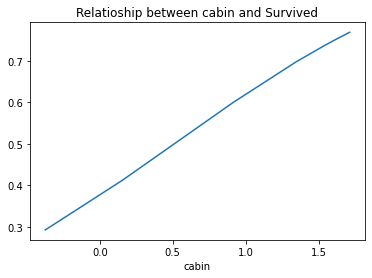

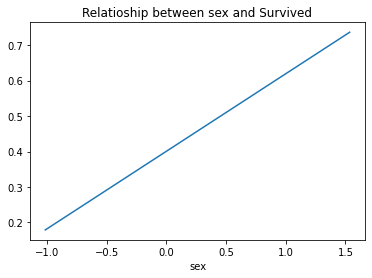

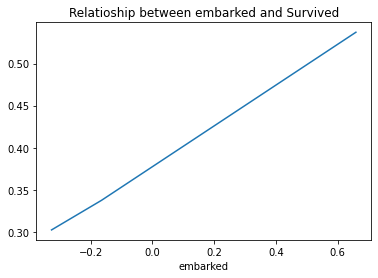

In [62]:
for var in ['cabin', 'sex', 'embarked']:

    X_train.groupby([var])['survived'].mean().plot()
    plt.title('Relatioship between {} and Survived'.format(var))
    plt.show();

You can see that the relationship between the target and the categories of the categorical variables goes up and down, depending on the category.


## Weight of Evidence with pandas


### Advantages

- quick
- returns pandas dataframe

### Limitations of pandas:

- it does not preserve information from train data to propagate to test data

We need to store the mappings separately if planning to use the model in production.

In [77]:
# lets get the mean values of the target variables for each label of cabin
# this will give the mean when target = 1, that is the survived group

total_survived = X_train['survived'].sum()
#total_survived
survived = X_train.groupby(['cabin'])['survived'].sum()/total_survived
survived

cabin
A    0.020408
B    0.090379
C    0.122449
D    0.067055
E    0.061224
F    0.029155
G    0.008746
n    0.600583
Name: survived, dtype: float64

In [78]:
# create a flag for those not survived

X_train['non_survived'] = np.where(X_train['survived'] == 1,0,1)

In [79]:
# get the values for non_survived
total_non_survived =len(X_train) - total_survived
#total_survived
non_survived = X_train.groupby(['cabin'])['non_survived'].sum()/total_non_survived
non_survived

cabin
A    0.017513
B    0.019264
C    0.049037
D    0.017513
E    0.015762
F    0.005254
G    0.001751
n    0.873905
Name: non_survived, dtype: float64

In [80]:
# now lets combine these two and get the woe

temp_df = pd.concat([survived, non_survived], axis = 1)
temp_df

,survived,non_survived
cabin,,
A,0.020408,0.017513
B,0.090379,0.019264
C,0.122449,0.049037
D,0.067055,0.017513
E,0.061224,0.015762
F,0.029155,0.005254
G,0.008746,0.001751
n,0.600583,0.873905


In [81]:
# calculate the woe

temp_df['woe'] = np.log(temp_df['survived']/temp_df['non_survived'])
temp_df

,survived,non_survived,woe
cabin,,,
A,0.020408,0.017513,0.152984
B,0.090379,0.019264,1.545751
C,0.122449,0.049037,0.915124
D,0.067055,0.017513,1.342568
E,0.061224,0.015762,1.356957
F,0.029155,0.005254,1.713632
G,0.008746,0.001751,1.608271
n,0.600583,0.873905,-0.375071


In [82]:
# lets convert it into a dictionary for mapping
var_mapping = temp_df['woe'].to_dict()
var_mapping

{'A': 0.1529838185513379,
 'B': 1.545750694176846,
 'C': 0.9151238705982346,
 'D': 1.3425678854251744,
 'E': 1.356956622877274,
 'F': 1.7136315668160063,
 'G': 1.60827105115818,
 'n': -0.37507116447186734}

In [83]:
# now we can mapped with the values of cabin
# now we can mapped with the values of cabin
X_train['cabin'] = X_train['cabin'].map(var_mapping)
X_train['cabin'].head(10)

843    -0.375071
869    -0.375071
430    -0.375071
481    -0.375071
1308   -0.375071
456    -0.375071
118     1.342568
485     1.342568
297    -0.375071
263     1.356957
Name: cabin, dtype: float64

In [85]:
# do the same for test data
X_test['cabin'] = X_test['cabin'].map(var_mapping)
X_test['cabin'].head(10)

612    -0.375071
415    -0.375071
531    -0.375071
1150   -0.375071
945    -0.375071
873     1.713632
5       1.356957
233     0.915124
734    -0.375071
1292   -0.375071
Name: cabin, dtype: float64

In [86]:
## write the functions to perform these functions

def find_category_mappings(df, variable, target):

    # copy of the original dataframe, so we do not accidentally
    # modify it
    tmp = df.copy()

    # total positive class
    total_pos = df[target].sum()

    # total negative class
    total_neg = len(df) - df[target].sum()

    # non target
    tmp['non-target'] = 1 - tmp[target]

    # % of positive class per category, respect to total positive class
    pos_perc = tmp.groupby([variable])[target].sum() / total_pos

    # % of negative class per category, respect to total negative class
    neg_perc = tmp.groupby([variable])['non-target'].sum() / total_neg

    # let's concatenate
    prob_tmp = pd.concat([pos_perc, neg_perc], axis=1)

    # let's calculate the Weight of Evidence
    prob_tmp['woe'] = np.log(prob_tmp[target]/prob_tmp['non-target'])

    return prob_tmp['woe'].to_dict()


# peform encoding
def mean_encode(X_train, X_test, var, mapping):
    X_train[var] = X_train[var].map(mapping)
    X_test[var] = X_test[var].map(mapping)

In [87]:
# and now we run a loop over the remaining categorical variables

for variable in ['sex', 'embarked']:
    mappings = find_category_mappings(X_train, variable, 'survived')
    mean_encode(X_train, X_test, variable, mappings)

In [88]:
# check the results
X_train.head()

,cabin,sex,embarked,survived,non_survived
843,-0.375071,-1.013111,-0.164796,0,1
869,-0.375071,-1.013111,-0.164796,0,1
430,-0.375071,1.535068,-0.164796,1,0
481,-0.375071,1.535068,0.658871,1,0
1308,-0.375071,-1.013111,-0.164796,0,1


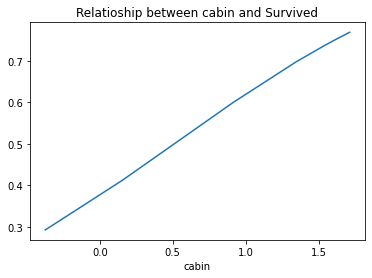

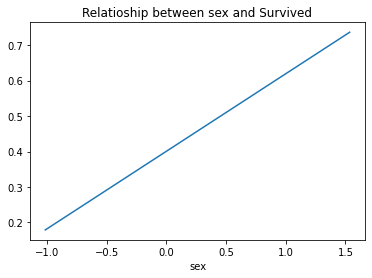

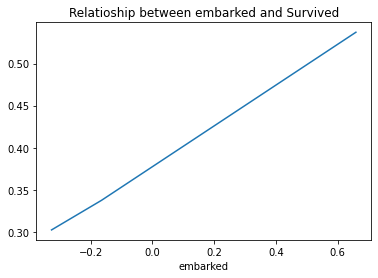

In [89]:
# now lets inspect the newly created monotonic relationship

for var in ['cabin', 'sex', 'embarked']:

    X_train.groupby([var])['survived'].mean().plot()
    plt.title('Relatioship between {} and Survived'.format(var))
    plt.show();

Now we can see monotonic relationship between the mean target and the categories.

In [90]:
X_test.head()

,cabin,sex,embarked,survived
612,-0.375071,1.535068,-0.164796,1
415,-0.375071,1.535068,-0.164796,1
531,-0.375071,-1.013111,0.658871,0
1150,-0.375071,-1.013111,-0.164796,0
945,-0.375071,-1.013111,-0.164796,1


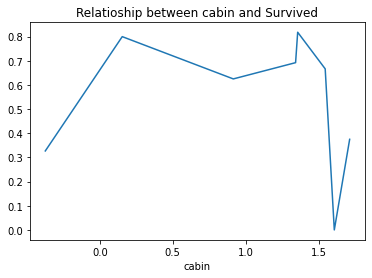

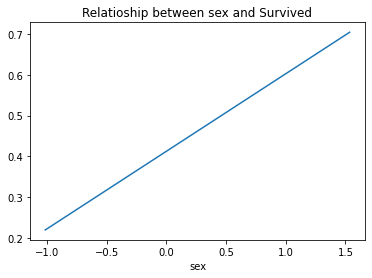

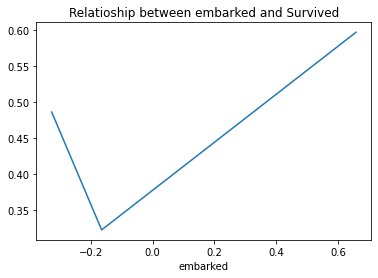

In [91]:
# now lets inspect the newly created monotonic relationship - test data

for var in ['cabin', 'sex', 'embarked']:

    X_test.groupby([var])['survived'].mean().plot()
    plt.title('Relatioship between {} and Survived'.format(var))
    plt.show();

The monotonic relationship does not hold when encoding the categorical variables in the test set. This could mean that the categories are not informative of the target or the proportion of survivors is not homogeneous between in the categories in the train and test sets. 

In situations like this, we could try grouping rare labels into a joint category as we will cover later in this section, before applying the Weight of evidence transformation.

### Note

Replacing categorical labels with this code and method will generate missing values for categories present in the test set that were not seen in the training set. Therefore it is extremely important to handle rare labels before-hand. I will explain how to do this, in a later notebook.

**In addition, it will create NA or Inf if any of the 2 terms in the ratio of the WoE formula are 0**

## Weight of Evidence with Feature-Engine

In [92]:
# split the data

X_train, X_test, y_train, y_test = train_test_split(data[cols],
                                                   data['survived'],
                                                   test_size=0.3,
                                                   random_state=0)

X_train.shape, X_test.shape

((914, 4), (392, 4))

In [93]:
# create feature-engine mean encoder object

woe_encoder = fe_WoEEncoder(variables= ['cabin', 'sex', 'embarked'])

In [94]:
# fitting the oie object
woe_encoder.fit(X_train, y_train)

WoEEncoder(variables=['cabin', 'sex', 'embarked'])

In [95]:
# check the object properties
woe_encoder.encoder_dict_

{'cabin': {'A': 0.1529838185513379,
  'B': 1.545750694176846,
  'C': 0.9151238705982346,
  'D': 1.3425678854251744,
  'E': 1.356956622877274,
  'F': 1.7136315668160063,
  'G': 1.60827105115818,
  'n': -0.37507116447186734},
 'sex': {'female': 1.535067647134885, 'male': -1.0131107672983564},
 'embarked': {'C': 0.658871160676746,
  'Q': -0.3265892617105483,
  'S': -0.16479628505772237}}

In [96]:
woe_encoder.variables

['cabin', 'sex', 'embarked']

In [98]:
# now transformation

X_train = woe_encoder.transform(X_train)
X_test = woe_encoder.transform(X_test)

# let's explore the result
X_train.head()

,cabin,sex,embarked,survived
843,-0.375071,-1.013111,-0.164796,0
869,-0.375071,-1.013111,-0.164796,0
430,-0.375071,1.535068,-0.164796,1
481,-0.375071,1.535068,0.658871,1
1308,-0.375071,-1.013111,-0.164796,0


**Note**

If the argument variables is left to None, then the encoder will automatically identify all categorical variables.

The encoder will not encode numerical variables. So if some of your numerical variables are in fact categories, you will need to re-cast them as object before using the encoder.

Finally, if there is a label in the test set that was not present in the train set, the encoder will through and error, to alert you of this behaviour.

## Weight of Evidence with Category Encoders

If using Category encpders, instead of pandas, we do not need to keep the target variable in the training dataset.

In [99]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked']],  # predictors
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((914, 3), (392, 3))

In [100]:
woe_enc = WOEEncoder(cols=['cabin', 'sex', 'embarked'])

In [101]:
woe_enc.fit(X_train, y_train)

WOEEncoder(cols=['cabin', 'sex', 'embarked'])

In [102]:
woe_enc.mapping

{'cabin': cabin
  1   -0.374548
  2    1.287500
  3    1.295799
  4    0.901246
  5    1.518942
  6    0.188888
  7    1.488171
  8    1.200488
 -1    0.000000
 -2    0.000000
 dtype: float64,
 'sex': sex
  1   -1.008094
  2    1.525265
 -1    0.000000
 -2    0.000000
 dtype: float64,
 'embarked': embarked
  1   -0.164851
  2    0.654977
  3   -0.307696
 -1    0.000000
 -2    0.000000
 dtype: float64}

- Here, the index names are not matched up with the category labels like we saw in Feature-Engine

In [103]:
X_train = woe_enc.transform(X_train)
X_test = woe_enc.transform(X_test)

# let's explore the result
X_train.head()

,cabin,sex,embarked
843,-0.374548,-1.008094,-0.164851
869,-0.374548,-1.008094,-0.164851
430,-0.374548,1.525265,-0.164851
481,-0.374548,1.525265,0.654977
1308,-0.374548,-1.008094,-0.164851
